### Installing needed libraries  
##Pickle helps save the DataFrame on the disk for future use. Here, the same DataFrame will be loaded again

In [1]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter

# for feature 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# for models
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#LDA modelling
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim as gensimvis

# for preety pictures
import matplotlib.pyplot as plt
import seaborn as sns

# Hide Warnings
Warning = False
if Warning is False:
    import warnings
    warnings.filterwarnings(action='ignore')
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
filename = 'preprocess_done_complaints.pickle'


infile = open(filename,'rb')
df_complain_product = pickle.load(infile)
infile.close()

#### varify information in dataframe and its type

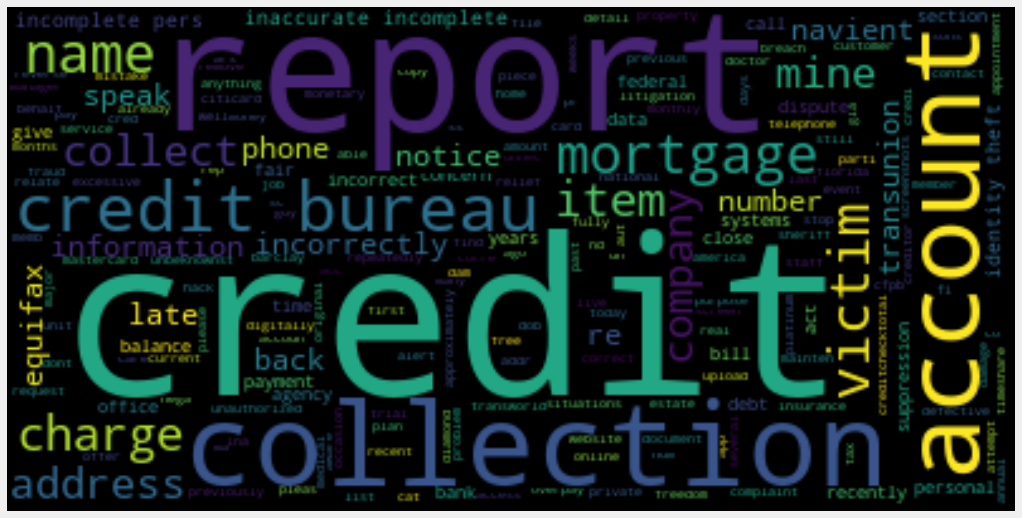

In [3]:
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

text= df_complain_product['lemm_tokens']

wordcloud = WordCloud().generate(str(text))

fig = plt.figure(
    figsize = (14, 10),
    facecolor = '#F0F0F0',
    edgecolor = '#F0F0F0')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [3]:
print(type(df_complain_product))

<class 'pandas.core.frame.DataFrame'>


In [4]:
df_complain_product.shape

(285703, 3)

In [5]:
df_complain_product.columns

Index(['product', 'consumer_disputed', 'lemm_tokens'], dtype='object')

#### examining the 20 most common for each product 

In [ ]:
def productwise_most_common_word(product):
    
    words=df_complain_product[df_complain_product['product'] == product]['lemm_tokens']
    word_all = []
    for word in words:
        word_all += word
    counter = Counter(word_all)
    return counter.most_common(20)


In [ ]:
for pname in set(df_complain_product['product']):
    print('Product Name :', pname)
    print('frequent 20 words:', productwise_most_common_word(pname))
    print('---')

### calculating TFIDF for complaint using TfidfVectorizer.  
1  Here min_df is used which is also known as cut_off.When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. Here it is 5. 
2  ngram_range(1,2) helps in creating unigram and bigram 
3  Max_df - threshold of higher frequency for each word.

In [6]:
# Tf- IDF vectorisation
tfidf_vector=TfidfVectorizer(min_df=5, ngram_range=(1, 2), max_df= .80)
corpus = df_complain_product['lemm_tokens'].astype(str)
complaint_tfmatrix= tfidf_vector.fit_transform( corpus)

### Check the shape of Matrix generated 

In [7]:
complaint_tfmatrix.shape

(285703, 415877)

### Encode labels into categorical variable: 
In order to create numeric representation for the product labels pandass.factorize() is used

In [8]:
df_complain_product['product_id'] = df_complain_product['product'].factorize()[0]

In [9]:
df_complain_product.groupby(['product','product_id']).count()

,,consumer_disputed,lemm_tokens
product,product_id,,
Bank account or service,13,7328,7328
Checking or savings account,7,0,11855
Consumer Loan,10,4514,4514
Credit card,9,9111,9111
Credit card or prepaid card,6,0,19979
Credit reporting,12,15976,15976
"Credit reporting, credit repair services, or other personal consumer reports",1,0,92818
Debt collection,0,19859,60147
"Money transfer, virtual currency, or money service",2,0,5057


### split the dataset
Create train dataset and test dataset in th ratio of 2:3
Check the shape of train and test dataset

In [12]:
complaint_label = df_complain_product['product_id']
X_train, X_test, Y_train, Y_test = train_test_split(complaint_tfmatrix, complaint_label, test_size=0.3, random_state=5)

In [13]:
X_train.shape

(199992, 415877)

In [14]:
X_test.shape

(85711, 415877)

In [15]:
Y_train.shape

(199992,)

In [16]:
Y_test.shape

(85711,)

###  LogisticRegression model

In [17]:
# create model using multi_class as multinomial / auto  for multiclass classification.

model_logisticR = LogisticRegression(multi_class='multinomial', C=0.5, penalty ='l2', solver='lbfgs').fit(X_train,Y_train)
#model_logisticR = LogisticRegression(multi_class='auto', C=0.5, penalty ='l2', solver='lbfgs').fit(X_train,Y_train)


In [18]:
predicted_logisticR= model_logisticR.predict(X_test)
print("LogisticRegression Accuracy:",metrics.accuracy_score(Y_test, predicted_logisticR))

LogisticRegression Accuracy: 0.7380266243539335


### Naive Bayes Model

In [19]:
# Model Generation Using Multinomial Naive Bayes

model_NB = MultinomialNB().fit(X_train, Y_train)
predicted_NB= model_NB.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(Y_test, predicted_NB))

MultinomialNB Accuracy: 0.6562401558726418


### SVM Model

In [20]:
# LinearSvc is used for multi-class classification

model_linear_svc = LinearSVC().fit(X_train, Y_train)
predicted_linear_svc = model_linear_svc.predict(X_test)
print("LinearSVC Accuracy:",metrics.accuracy_score(Y_test, predicted_linear_svc))

LinearSVC Accuracy: 0.7589107582457327


### Random Forest Model

In [21]:
# create random forest model 

model_random_Forest = RandomForestClassifier().fit(X_train, Y_train)
predicted_random_Forest= model_random_Forest.predict(X_test)
print("RandomForestClassifier Accuracy:",metrics.accuracy_score(Y_test, predicted_random_Forest))



RandomForestClassifier Accuracy: 0.6759575783738376


### Listong the metrics accuracy for all model for comparison

In [ ]:
print("LogisticRegression Accuracy:",metrics.accuracy_score(Y_test, predicted_logisticR))
print("MultinomialNB Accuracy:",metrics.accuracy_score(Y_test, predicted_NB))
print("LinearSVC Accuracy:",metrics.accuracy_score(Y_test, predicted_linear_svc))
print("RandomForestClassifier Accuracy:",metrics.accuracy_score(Y_test, predicted_random_Forest))

### use sns plot to compare the accuracy

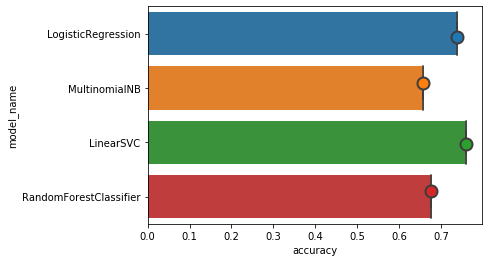

In [24]:
model_data = [['LogisticRegression', metrics.accuracy_score(Y_test, predicted_logisticR),
               metrics.f1_score(Y_test, predicted_logisticR ,average='macro') ]  ,
         ['MultinomialNB', metrics.accuracy_score(Y_test, predicted_NB),
             metrics.f1_score(Y_test, predicted_NB ,average='macro')] ,
         ['LinearSVC', metrics.accuracy_score(Y_test, predicted_linear_svc),
             metrics.f1_score(Y_test, predicted_linear_svc ,average='macro')],
         ['RandomForestClassifier',metrics.accuracy_score(Y_test, predicted_random_Forest),
             metrics.f1_score(Y_test, predicted_random_Forest ,average='macro')]  ] 

model_df = pd.DataFrame(model_data, columns=['model_name', 'accuracy' , 'f1_score'])


sns.boxplot(x='accuracy', y='model_name', data=model_df)
sns.stripplot(x='accuracy', y='model_name', data=model_df,size=12 , edgecolor="gray", linewidth=2)
sns.barplot(x='accuracy', y='model_name', data=model_df)
plt.show()

Parameter tuning:  The value of C = 1/λ , is regularisation parameter. 

In [25]:

for c in [0.15 , 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    #model_logisticR = LogisticRegression(C=c).fit(X_train,Y_train)   
    model_logisticR = LogisticRegression(multi_class='multinomial', C=c, penalty ='l2', solver='lbfgs').fit(X_train,Y_train)
    predicted_logisticR= model_logisticR.predict(X_test)
    print("LogisticRegression Accuracy: for C =%s: %s"%(c,metrics.accuracy_score(Y_test, predicted_logisticR)))
    
    

LogisticRegression Accuracy: for C =0.01: 0.6285190932319072
LogisticRegression Accuracy: for C =0.05: 0.6955933310776913
LogisticRegression Accuracy: for C =0.25: 0.7303146620620458
LogisticRegression Accuracy: for C =0.5: 0.7380266243539335
LogisticRegression Accuracy: for C =1: 0.7422034511322934


In [ ]:

model_logisticR = LogisticRegression(C=1).fit(X_train,Y_train)

predicted_logisticR= model_logisticR.predict(X_test)
print("LogisticRegression Accuracy:",metrics.accuracy_score(Y_test, predicted_logisticR))


### Classification report 
check how each class is getting classified with the model .

In [26]:
# Classification report
#from sklearn import metrics
print(metrics.classification_report(Y_test, predicted_logisticR, target_names=df_complain_product['product'].unique()))


                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.79      0.85      0.82     18078
Credit reporting, credit repair services, or other personal consumer reports       0.74      0.89      0.81     27754
                          Money transfer, virtual currency, or money service       0.72      0.72      0.72      1509
                                                                    Mortgage       0.89      0.93      0.91     10269
                                                                Student loan       0.87      0.83      0.85      4241
                                                       Vehicle loan or lease       0.54      0.43      0.48      1473
                                                 Credit card or prepaid card       0.60      0.74      0.66      5965
                                                 Checki

### display confusion matrix 

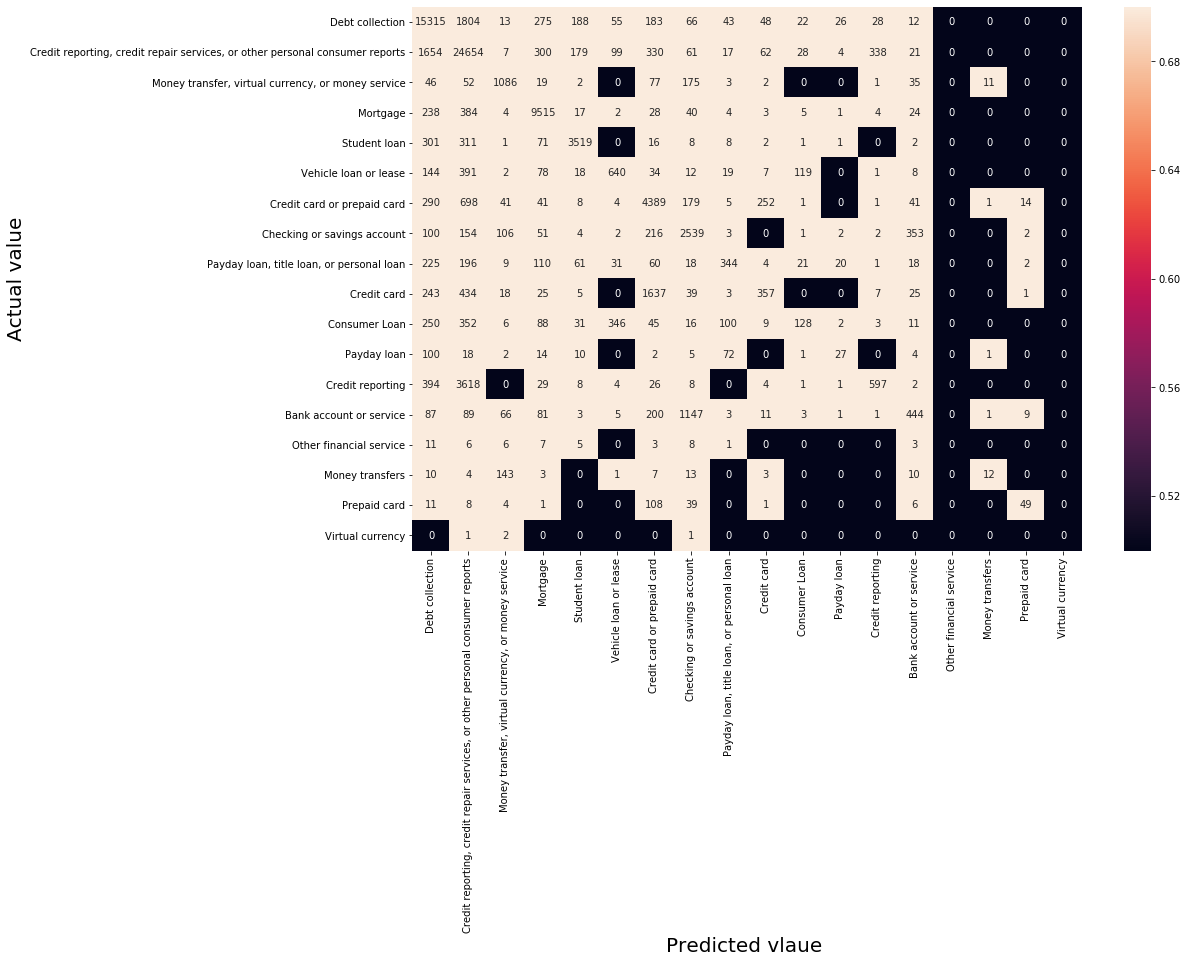

In [27]:

df_prod_prodID = df_complain_product[['product',  'product_id']].drop_duplicates().sort_values('product_id') 
confusion_matrix_var= confusion_matrix(Y_test, predicted_logisticR)
fig, ax = plt.subplots(figsize=(15,10))



xlabels=df_prod_prodID['product'].values
ylabels=df_prod_prodID['product'].values

sns.heatmap(confusion_matrix_var,  annot= True , xticklabels =xlabels, yticklabels= ylabels, fmt= 'd' , vmin=0.5,vmax=0.7)
plt.ylabel('Actual value', fontsize=20)
plt.xlabel('Predicted vlaue ', fontsize=20)
plt.show()

### validation
Let us use the model on unknown dataset. 

In [29]:
texts_to_verify = ["It has been over 45 days, the legal amount of time they have to investigate the items.",
                   "I have applied for personal home loan through Barclays Bank .They have not answered yet.",
                   "I can't withdraw money in other country. it is reaaly frustrating.",
                   " It has been difficult for me to find my past due balance.",
                   "It has been over 45 days, the legal amount of time they have to investigate the items.",
                   "I am not able to check my credit card charges. I missed a regular monthly payment",
                   "Paypal closed my account for no reason ",
                   " repeatedly they have showen negligence in removing fraudulent items from my report",
                   "I would like to get extra credit for my account with bank of Honolulu"]

features_found = tfidf_vector.transform(texts_to_verify)

predictions_by_model = model_logisticR.predict(features_found)

for text, predicted in zip(texts_to_verify, predictions_by_model):
    print('"{}"'.format(text))
    print('Model Prediction is =', predicted)
    

"It has been over 45 days, the legal amount of time they have to investigate the items."
Model Prediction is = 1
"I have applied for personal home loan through Barclays Bank .They have not answered yet."
Model Prediction is = 3
"I can't withdraw money in other country. it is reaaly frustrating."
Model Prediction is = 7
" It has been difficult for me to find my past due balance."
Model Prediction is = 1
"It has been over 45 days, the legal amount of time they have to investigate the items."
Model Prediction is = 1
"I am not able to check my credit card charges. I missed a regular monthly payment"
Model Prediction is = 1
"Paypal closed my account for no reason "
Model Prediction is = 2
" repeatedly they have showen negligence in removing fraudulent items from my report"
Model Prediction is = 1
"I would like to get extra credit for my account with bank of Honolulu"
Model Prediction is = 1


## TASK 2
perform topic modelling, using LDAmodel, and check the topics created and text classified correctly. 

In [ ]:
#create dictionary

word_corpus_dict = gensim.corpora.Dictionary(df_complain_product.lemm_tokens)

In [ ]:
word_corpus_dict.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

In [ ]:
#create corpus : Term document Frequency

bow_corpus = [word_corpus_dict.doc2bow(word) for word in df_complain_product.lemm_tokens]

In [ ]:
# Check one item  
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     word_corpus_dict[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

In [ ]:
#build LDA model


lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=10, id2word=word_corpus_dict, passes=2 )

In [ ]:
# print topic and most frequent word related to that topic
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

validation of LDA model 

In [ ]:
print('\nPerplexity Score: ', lda_model.log_perplexity(bow_corpus))

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=df_complain_product.lemm_tokens, dictionary=word_corpus_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


In [ ]:
pyLDAvis_corpus = gensimvis.prepare(lda_model, bow_corpus, word_corpus_dict)
pyLDAvis.display(pyLDAvis_corpus)

## Task 3  Binary classification 
Using logistic regression data is getting classified, if the consumer will dispute or not

Checking the dataframe for null value and deleting it if any exist.

In [30]:
df_complain_product.isnull().sum()

product                   0
consumer_disputed    205033
lemm_tokens               0
product_id                0
dtype: int64

In [31]:

df_complain_product = df_complain_product.dropna(axis=0, subset=['consumer_disputed'])
df_complain_product.shape

(80670, 4)

### creating TFIDF matrix  unigram and bigram using lemma tokens

In [33]:
tfidf_vector=TfidfVectorizer(min_df=5, ngram_range=(1, 2))
corpus = df_complain_product['lemm_tokens'].astype(str)
complaint_tfmatrix= tfidf_vector.fit_transform( corpus)

In [34]:
complaint_tfmatrix.shape

(80670, 148334)

### Label encoder is used to generate numeric representation of lables. 

In [35]:

label_encoder = LabelEncoder()

df_complain_product['consumer_disputed_id'] = 
label_encoder.fit_transform(df_complain_product['consumer_disputed'].astype(str))

In [36]:
df_complain_product.head(2)

,product,consumer_disputed,lemm_tokens,product_id,consumer_disputed_id
176,Debt collection,Yes,"[monitor, credit, report, frequently, buy, fir...",0,1
225,Debt collection,No,"[letter, ara, inc, debt, collection, agency, o...",0,0


In [ ]:
df_upheld = df_complain_product[['consumer_disputed','consumer_disputed_id']].drop_duplicates().sort_values('consumer_disputed_id') 
df_upheld

### split the data 
split the data as per newly crated labels, train dataset for traing and test dataset for validation 

In [37]:
dispute_label = df_complain_product['consumer_disputed_id']
X_train, X_test, Y_train, Y_test = train_test_split(complaint_tfmatrix, dispute_label, test_size=0.3, random_state=0)

In [44]:

model_logisticR = LogisticRegression( C=0.8, penalty ='l2', solver='liblinear').fit(X_train,Y_train)

predicted_logisticR= model_logisticR.predict(X_test)
print("LogisticRegression Accuracy:",metrics.accuracy_score(Y_test, predicted_logisticR))

LogisticRegression Accuracy: 0.7856286930292137


classification report to check the precision, f1-score and support

In [39]:
print(metrics.classification_report(Y_test, predicted_logisticR, target_names=df_complain_product['consumer_disputed'].unique()))

              precision    recall  f1-score   support

         Yes       0.79      0.99      0.88     18972
          No       0.57      0.04      0.07      5229

    accuracy                           0.79     24201
   macro avg       0.68      0.51      0.47     24201
weighted avg       0.74      0.79      0.70     24201



In [ ]:
### confusion matrix to check the classification.

KeyboardInterrupt: 

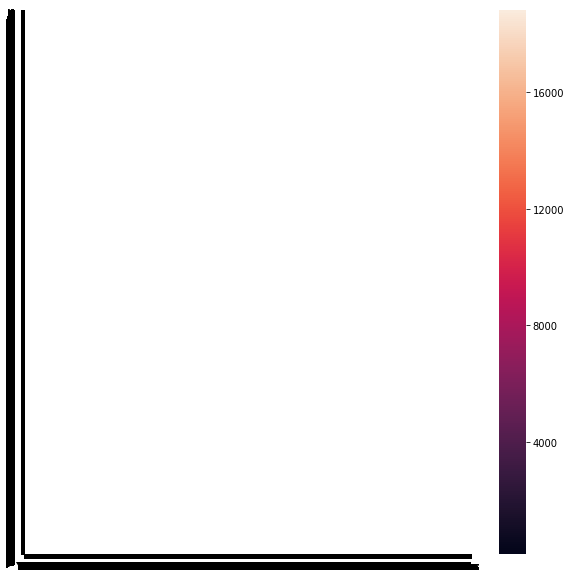

In [41]:
confusion_matrix_var= confusion_matrix(Y_test, predicted_logisticR)
fig, ax = plt.subplots(figsize=(10,10))


xlabels=df_complain_product['consumer_disputed'].values
ylabels=df_complain_product['consumer_disputed'].values

sns.heatmap(confusion_matrix_var,  annot= True , xticklabels =xlabels, yticklabels= ylabels, fmt= 'g' )

plt.ylabel('Actual value')
plt.xlabel('Predicted vlaue ')
plt.show()

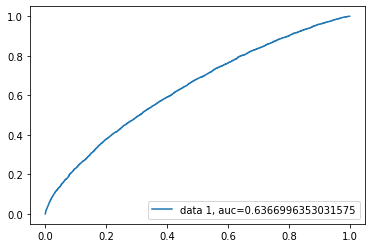

In [45]:
y_pred_proba = model_logisticR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [46]:
# Some manual tests for new input data
texts_to_verify = ["It has been over 45 days, the legal amount of time they have to investigate the items.",
                   "Thanks for quick response",
                   "I have applied for personal home loan through Barclays Bank .They have not answered yet.",
                   " repeatedly they have showen negligence in removing fraudulent items from my report",
                   "Happy to get the card sorted",
                   "this is empty string",
                   "I would like to get extra credit for my account with bank of Honolulu"]
features_found = tfidf_vector.transform(texts_to_verify)
predictions_by_model = model_logisticR.predict(features_found)
for text, predicted in zip(texts_to_verify, predictions_by_model):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(predicted_logisticR[predicted]))

"It has been over 45 days, the legal amount of time they have to investigate the items."
  - Predicted as: '0'
"Thanks for quick response"
  - Predicted as: '0'
"I have applied for personal home loan through Barclays Bank .They have not answered yet."
  - Predicted as: '0'
" repeatedly they have showen negligence in removing fraudulent items from my report"
  - Predicted as: '0'
"Happy to get the card sorted"
  - Predicted as: '0'
"this is empty string"
  - Predicted as: '0'
"I would like to get extra credit for my account with bank of Honolulu"
  - Predicted as: '0'
